This is a demo script that pretrains the classical 2D U-Net with an autoencoder, for mitochondria segmentation in volume electron microscopy data. 

Let's start with importing the required packages. 

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import argparse
import datetime
import torch
from torch.utils.data import DataLoader
from copy import deepcopy

from data.datasets import StronglyLabeledVolumeDataset, UnlabeledVolumeDataset
from networks.unet import UNet2D
from util.losses import CrossEntropyLoss, MSELoss
from util.preprocessing import get_augmenters_2d
from util.validation import segment
from util.metrics import jaccard, dice, accuracy_metrics
from util.tools import overlay

Let's start by loading the data and a quick visualisation! 

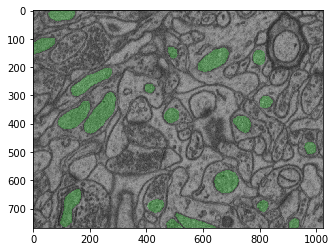

In [2]:
data_train = "../data/epfl/training.tif"
labels_train = "../data/epfl/training_groundtruth.tif"
data_test = "../data/epfl/testing.tif"
labels_test = "../data/epfl/testing_groundtruth.tif"
data_unsupervised_train = "../data/epfl/training.tif"
data_unsupervised_test = "../data/epfl/testing.tif"

input_shape = (1, 128, 128)

train_xtransform, train_ytransform, test_xtransform, test_ytransform = get_augmenters_2d()
train_xtransform_us, train_ytransform_us, test_xtransform_us, test_ytransform_us = get_augmenters_2d()

train = StronglyLabeledVolumeDataset(data_train, labels_train, input_shape, transform=train_xtransform, target_transform=train_ytransform, preprocess='unit')
test = StronglyLabeledVolumeDataset(data_test, labels_test, input_shape, transform=test_xtransform, target_transform=test_ytransform, preprocess='unit')
train_unsupervised = UnlabeledVolumeDataset(data_unsupervised_train, input_shape, transform=train_xtransform_us)
test_unsupervised = UnlabeledVolumeDataset(data_unsupervised_test, input_shape=input_shape, transform=train_xtransform_us)

plt.imshow(overlay(test.data[0,...],test.labels[0,...], alpha=0.2))

Right. Now let's put this data in a dataloader for easy use in PyTorch. We will use a batch size of 4 for training and testing both networks. You can make this smaller or larger depending on your computational resources. 

In [3]:
batch_size = 4

train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)
train_loader_unsupervised = DataLoader(train_unsupervised, batch_size=batch_size)
test_loader_unsupervised = DataLoader(test_unsupervised, batch_size=batch_size)

We are now ready to define and train the autoencoder network (i.e. U-Net without skip connections)! For computational simplicity, we will use a slightly smaller version of the original U-Net. We will train the network with MSE loss for 10 epochs with learning rate of 0.01 with multiplicative decay (decay factor 0.9) every epoch. We will test the network after every epoch and print out some logging statistics every 50 iterations. 

In [4]:
net_us = UNet2D(out_channels=1, feature_maps=16, pretrain_unsupervised=True)

loss_fn_rec = MSELoss()
lr = 1e-3
step_size = 1
gamma = 0.9
epochs = 10
test_freq = 1
print_stats = 50
log_dir = "logs"

net_us.train_net(train_loader=train_loader_unsupervised, test_loader=test_loader_unsupervised,
                 loss_fn=loss_fn_rec, lr=lr, step_size=step_size, gamma=gamma,
                 epochs=epochs, test_freq=test_freq, print_stats=print_stats, log_dir=log_dir)

[2019-02-14 14:34:15.495123] Starting unsupervised pre-training
[2019-02-14 14:34:15.495454] Epoch     0/   10
[2019-02-14 14:34:17.324370] Epoch     0 - Iteration     0/  250 - Loss: 0.030329
[2019-02-14 14:34:19.534863] Epoch     0 - Iteration    50/  250 - Loss: 0.022081
[2019-02-14 14:34:21.660929] Epoch     0 - Iteration   100/  250 - Loss: 0.016477
[2019-02-14 14:34:23.882381] Epoch     0 - Iteration   150/  250 - Loss: 0.017845
[2019-02-14 14:34:26.168744] Epoch     0 - Iteration   200/  250 - Loss: 0.010721
[2019-02-14 14:34:28.301317] Epoch     0 - Average train loss: 0.013423
[2019-02-14 14:34:36.742560] Epoch     0 - Average test loss: 0.011142
[2019-02-14 14:34:36.862036] Epoch     1/   10
[2019-02-14 14:34:36.917577] Epoch     1 - Iteration     0/  250 - Loss: 0.006877
[2019-02-14 14:34:38.991388] Epoch     1 - Iteration    50/  250 - Loss: 0.006913
[2019-02-14 14:34:41.118558] Epoch     1 - Iteration   100/  250 - Loss: 0.004662
[2019-02-14 14:34:43.197724] Epoch     1 - 

Ok, now let's check out how the reconstructions look like. 

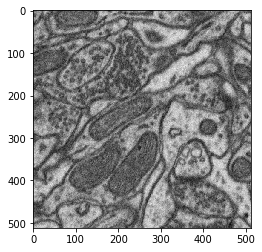

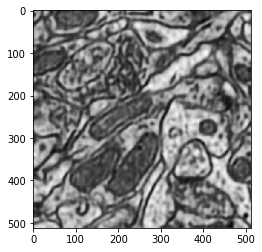

In [5]:
sample = test.data[0:1,:512,:512]
sample = torch.Tensor(sample[np.newaxis,...]).cuda()
sample_rec = net_us(sample)

plt.imshow(sample[0,0,...].cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(sample_rec[0,0,...].data.cpu().numpy(), cmap='gray')
plt.show()

That's not too bad. Seems like the autoencoder has learned some useful semantic features. Now it's time for training this network as a U-Net segmentation network! We will train the network with cross entropy loss for 10 epochs with learning rate of 0.01 with multiplicative decay (decay factor 0.9) every epoch. We will test the network after every epoch and print out some logging statistics every 50 iterations.

In [6]:
net = UNet2D(feature_maps=16, pretrain_unsupervised=False)
net.encoder = deepcopy(net_us.encoder)

loss_fn_seg = CrossEntropyLoss()
lr = 1e-2
step_size = 1
gamma = 0.9
epochs = 10
test_freq = 1
print_stats = 50
log_dir = "logs"

net.train_net(train_loader=train_loader, test_loader=test_loader,
              loss_fn=loss_fn_seg, lr=lr, step_size=step_size, gamma=gamma,
              epochs=epochs, test_freq=test_freq, print_stats=print_stats, log_dir=log_dir)

[2019-02-14 14:37:26.905047] Epoch     0/   10
[2019-02-14 14:37:26.963794] Epoch     0 - Iteration     0/  250 - Loss: 0.708603
[2019-02-14 14:37:30.453077] Epoch     0 - Iteration    50/  250 - Loss: 0.072500
[2019-02-14 14:37:34.229351] Epoch     0 - Iteration   100/  250 - Loss: 0.336278
[2019-02-14 14:37:37.926275] Epoch     0 - Iteration   150/  250 - Loss: 0.087363
[2019-02-14 14:37:41.486391] Epoch     0 - Iteration   200/  250 - Loss: 0.098197
[2019-02-14 14:37:44.900212] Epoch     0 - Average train loss: 0.160825
[2019-02-14 14:37:48.401476] Epoch     0 - Average test loss: 0.098547
[2019-02-14 14:37:48.517045] Epoch     1/   10
[2019-02-14 14:37:48.593721] Epoch     1 - Iteration     0/  250 - Loss: 0.091332
[2019-02-14 14:37:52.123148] Epoch     1 - Iteration    50/  250 - Loss: 0.121337
[2019-02-14 14:37:55.433558] Epoch     1 - Iteration   100/  250 - Loss: 0.095717
[2019-02-14 14:37:59.042765] Epoch     1 - Iteration   150/  250 - Loss: 0.088598
[2019-02-14 14:38:02.2811

Great! Let's segment the first slice of our test dataset and validate it! 

Validation results:
     Jaccard: 0.772835
     Dice: 0.871863
     Accuracy: 0.979786
     Precision: 0.898493
     Recall: 0.846767
     F-score: 0.871863


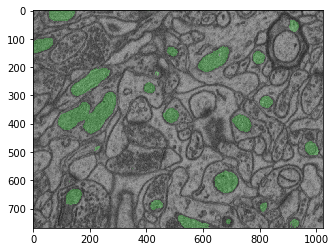

In [7]:
test_data = test.data[0:1,...]
test_labels = test.labels[0:1,...]
segmentation = segment(test_data, net, (128, 128), batch_size=batch_size)

plt.imshow(overlay(test_data[0, ...], segmentation[0, ...]>0.5, alpha=0.2))

j = jaccard(segmentation, test_labels)
d = dice(segmentation, test_labels)
a, p, r, f = accuracy_metrics(segmentation, test_labels)
print('Validation results:')
print('     Jaccard: %f' % (j))
print('     Dice: %f' % (d))
print('     Accuracy: %f' % (a))
print('     Precision: %f' % (p))
print('     Recall: %f' % (r))
print('     F-score: %f' % (f))

Of course the results can be improved significantly by increasing the capacity of the network and tuning the hyperparameters. 